# 1) Preparing dataset with augmented images

In [ ]:
import kagglehub #allows users to access various Kaggle resources
import numpy as np
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import matplotlib.pyplot as plt

path = kagglehub.dataset_download("mengcius/cinic10")
train_dir = path + "/train"
valid_dir = path + "/valid"
test_dir = path + "/test"

shutil.rmtree(os.path.join(os.path.dirname(path), "augmented_dir"), ignore_errors=True)
augmented_dir = os.path.join(os.path.dirname(path), "augmented_dir")
os.makedirs(augmented_dir, exist_ok=True)
EPOCHS = 50
tf.random.set_seed(20)
IMG_SIZE = (32,32)
BATCH_SIZE = 128

# Efekt Sepia
def apply_sobel(image):
    """ Wykrywanie krawędzi za pomocą filtra Sobela """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = cv2.magnitude(sobelx, sobely)

    # Normalizacja wartości do przedziału [0, 255]
    sobel_combined = np.uint8(255 * sobel_combined / np.max(sobel_combined))

    # Konwersja do RGB (powielenie kanału)
    sobel_combined = cv2.cvtColor(sobel_combined, cv2.COLOR_GRAY2RGB)
    return sobel_combined


# Gaussian Noise
def add_gaussian_noise(image):
    """ Dodaje subtelny szum Gaussa do obrazu """
    mean = 0
    stddev = 1 # intensywność szumu (zmiejszylem z 10 do 2)
    noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return np.clip(noisy_image, 0, 255)


# Obrót obrazu o dany kąt
def rotate_image(image, angle):
    """ Obraca obraz o dany kąt """
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    return rotated_image

# Konwersja na sepię
def to_sepia(image):
    """ Zmienia obraz na sepię """
    sepia_filter = np.array([[0.393, 0.769, 0.189],
                             [0.349, 0.686, 0.168],
                             [0.272, 0.534, 0.131]])
    sepia_image = cv2.transform(image, sepia_filter)
    return np.clip(sepia_image, 0, 255).astype(np.uint8)

# Konwersja na czarno-biały
def to_grayscale(image):
    """ Zmienia obraz na czarno-biały """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)  # Konwersja do formatu RGB
    return gray_rgb

# Crop obrazu
def crop_image(image):
    """ Przycinanie obrazu (crop) """
    h, w = image.shape[:2]
    crop_size = np.random.randint(24, 32)  # Losowy rozmiar
    x = np.random.randint(0, w - crop_size)
    y = np.random.randint(0, h - crop_size)
    cropped = image[y:y+crop_size, x:x+crop_size]
    return cv2.resize(cropped, (w, h))

# Stretch obrazu
def stretch_image(image):
    """ Rozciąganie obrazu (stretch) """
    h, w = image.shape[:2]
    stretch_factor = np.random.uniform(1.0, 1.5)
    stretched = cv2.resize(image, (int(w * stretch_factor), h))
    return cv2.resize(stretched, (w, h))


# 🔹 Tworzenie augmentowanych obrazów
def create_augmented_dir(train_dir, destination_dir):
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        augmented_class_path = os.path.join(destination_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        os.makedirs(augmented_class_path, exist_ok=True)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img).astype(np.uint8)

            for i in range(4):  # 4 różne kopie obrazu
                augmented = img_array

                # 1️⃣ Obrót o losowy kąt (0° - 20°)
                angle = np.random.uniform(0, 20)
                augmented = rotate_image(augmented, angle)

                # 2️⃣ Losowe odbicie lustrzane (50% szans)
                if np.random.rand() > 0.5:
                    augmented = np.fliplr(augmented)

                # 3️⃣ Losowy wybór efektu kolorystycznego
                if np.random.rand() < 0.5:
                    augmented = to_sepia(augmented)  # 50% na Sepia
                elif np.random.rand() < 0.5:
                    augmented = to_grayscale(augmented)  # 25% na grayscale

                # 4️⃣ Gaussian Noise (0.1% szans)
                if np.random.rand() < 0.001:
                    augmented = add_gaussian_noise(augmented)

                # 5️⃣ Sobel Filter (30% szans)
                if np.random.rand() < 0.3:
                    augmented = apply_sobel(augmented)

                # 6️⃣ Losowy Crop (20% szans) lub Stretch (20% szans)
                if np.random.rand() < 0.2:
                    augmented = crop_image(augmented)
                elif np.random.rand() < 0.2:
                    augmented = stretch_image(augmented)

                # Zapis obrazka
                augmented_img = array_to_img(augmented)
                augmented_img.save(os.path.join(augmented_class_path, f"aug_{i}_{img_name}"))

    return destination_dir

print("Augmentacja zakończona! Obrazy zapisane w:", create_augmented_dir(train_dir, augmented_dir))

train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,  # batches 128
    class_mode="sparse",
    shuffle=True
)
# mixed augmentation methods
augmented_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    augmented_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,  # Larger batches
    class_mode="sparse",
    shuffle=True
)
valid_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,  # Larger batches
    class_mode="sparse",
    shuffle=True
)

def combined_generator(gen1, gen2):
    while True:
        x1, y1 = next(gen1)
        x2, y2 = next(gen2)
        yield (np.concatenate([x1, x2]), np.concatenate([y1, y2]))

# Use combined generator
train_generator_450k_all = combined_generator(train_generator, augmented_generator)

100%|██████████| 754M/754M [00:15<00:00, 52.7MB/s]

Extracting files...


Augmentacja zakończona! Obrazy zapisane w: /root/.cache/kagglehub/datasets/mengcius/cinic10/versions/augmented_dir
Found 90000 images belonging to 10 classes.
Found 360000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


# 2) Modern architectures overview

# 🔍 CNN Architectures in Computer Vision

## 1. VGG (Visual Geometry Group)
Year: 2014  
Authors: Simonyan & Zisserman (Oxford)  
Paper: *Very Deep Convolutional Networks for Large-Scale Image Recognition*

### Key Features:
- Depth: 16 or 19 convolutional layers (VGG16 and VGG19).
- Convolutional blocks: Each block contains 2–3 Conv2D layers + MaxPooling.
- Filter size is consistently 3x3, providing a uniform architecture.
- Number of filters increases with depth (e.g., 64, 128, 256, 512).
- Dense layers at the end: usually two fully connected layers with 4096 units + softmax output layer.
- No Batch Normalization – can be unstable with large datasets.

### Applications:
- Image classification (e.g., ImageNet) – high accuracy.
- Feature extraction for transfer learning – used in object detection systems.
- Object detection & segmentation – used as a backbone in architectures like Mask R-CNN.

### Advantages:
- Very simple and consistent structure.
- High accuracy in classification tasks.

### Disadvantages:
- Huge number of parameters (~138M in VGG16).
- High memory and computational requirements.
- No batch normalization → slower training.

---

## 2. ResNet (Residual Network)
📅 Year: 2015  
👨‍🔬 Authors: He et al. (Microsoft Research)  
📚 Paper: *Deep Residual Learning for Image Recognition*

### Key Features:
- Residual blocks (skip connections) – bypassing one or more layers.
- Deep architectures: ResNet-18, ResNet-34, ResNet-50, ResNet-101, ResNet-152.
- Extremely deep models – up to 152 layers.

### Applications:
- Image classification (e.g., ImageNet).
- Transfer learning in many computer vision tasks.
- Object detection (YOLO, Faster R-CNN).
- Image segmentation (DeepLab, Mask R-CNN).

### Advantages:
- Solves the vanishing gradient problem.
- Very deep networks with excellent performance.

### Disadvantages:
- Computationally demanding for deeper versions.
- Skip connections may reduce interpretability.

---

## 3. Inception (GoogLeNet)
📅 Year: 2014  
👨‍🔬 Authors: Szegedy et al. (Google)  
📚 Paper: *Going Deeper with Convolutions*

### Key Features:
- Inception blocks:
  - Uses multiple filters in parallel (1x1, 3x3, 5x5).
  - Merges outputs by concatenating along the depth axis.
  - Dimensionality reduction using 1x1 bottleneck layers.
- Variants: Inception-v1, v2, v3, v4, Inception-ResNet.

### Applications:
- Image classification (ImageNet).
- Feature extraction and transfer learning.

### Advantages:
- Efficient multi-scale feature extraction.
- Dimensionality reduction via 1x1 convolutions.

### Disadvantages:
- Complex structure.
- Harder to customize and extend.

---

# 3) Implementations

## 3.1) VGG implementation

Path to source dataset files: /root/.cache/kagglehub/datasets/mengcius/cinic10/versions/1
Path to maly_zbior files: /root/.cache/kagglehub/datasets/mengcius/cinic10/versions/maly_zbior
Path to maly_zbior_test files: /root/.cache/kagglehub/datasets/mengcius/cinic10/versions/maly_zbior_test


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Augmentacja zakończona! Obrazy zapisane w: /root/.cache/kagglehub/datasets/mengcius/cinic10/versions/augmented_dir
Found 360000 images belonging to 10 classes.


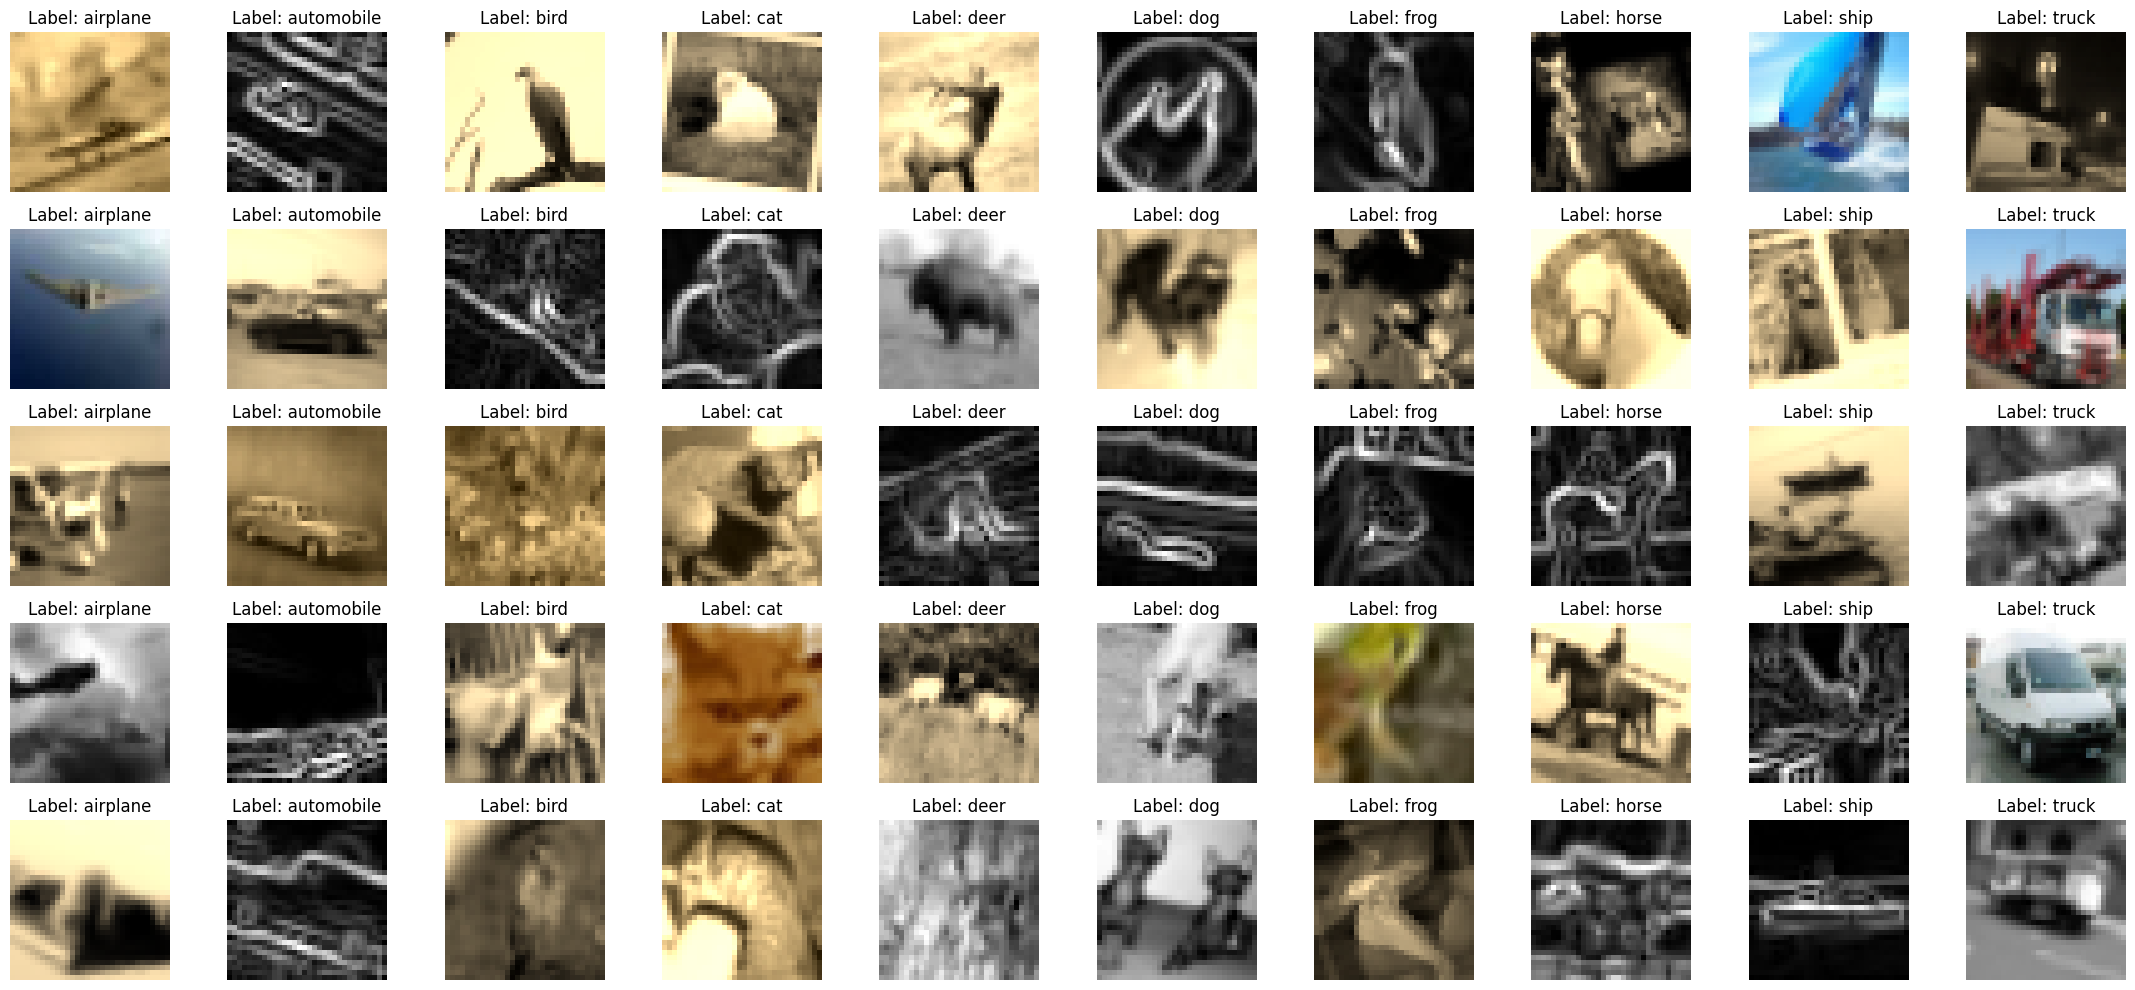

Found 90000 images belonging to 10 classes.
Found 360000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/50
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3630 - loss: 1.8388

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 280s 77ms/step - accuracy: 0.3630 - loss: 1.8387 - val_accuracy: 0.6242 - val_loss: 1.1404
Epoch 2/50
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 246s 70ms/step - accuracy: 0.5884 - loss: 1.3197 - val_accuracy: 0.6607 - val_loss: 1.1003
Epoch 3/50
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 245s 70ms/step - accuracy: 0.6334 - loss: 1.2268 - val_accuracy: 0.6759 - val_loss: 1.0995
Epoch 4/50
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 247s 70ms/step - accuracy: 0.6539 - loss: 1.1839 - val_accuracy: 0.7219 - val_loss: 0.9644
Epoch 5/50
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 250s 71ms/step - accuracy: 0.6660 - loss: 1.1609 - val_accuracy: 0.7363 - val_loss: 0.9351
Epoch 6/50
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 255s 73ms/step - accuracy: 0.6728 - loss: 1.1473 - val_accuracy: 0.7155 - val_loss: 1.0112
Epoch 7/50
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 257s 73ms/step - accuracy: 0.6787 - loss: 1.1365 - val_accuracy: 0.7270 - val_loss: 0.9781
Epoch 8/50
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 250s 71ms/step - accuracy: 0.6823 - lo

In [ ]:
IMG_SIZE = (32, 32)
datagen = ImageDataGenerator(rescale=1.0/255)

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers

vgg = models.Sequential([

          # Blok 1: 32 filtrów -> 16x16 map cech
          layers.Conv2D(32, (3, 3), padding='same', use_bias=False,
                        kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)),
          layers.BatchNormalization(),
          layers.Activation('relu'),
          layers.Conv2D(32, (3, 3), padding='same', use_bias=False,
                        kernel_regularizer=regularizers.l2(0.0001)),
          layers.BatchNormalization(),
          layers.Activation('relu'),
          layers.MaxPooling2D((2, 2)),  # Redukcja do 16x16
          layers.Dropout(0.2),           # Dropout 20% w pierwszym bloku

          # Blok 2: 64 filtrów -> 8x8 map cech
          layers.Conv2D(64, (3, 3), padding='same', use_bias=False,
                        kernel_regularizer=regularizers.l2(0.0001)),
          layers.BatchNormalization(),
          layers.Activation('relu'),
          layers.Conv2D(64, (3, 3), padding='same', use_bias=False,
                        kernel_regularizer=regularizers.l2(0.0001)),
          layers.BatchNormalization(),
          layers.Activation('relu'),
          layers.MaxPooling2D((2, 2)),  # Redukcja do 8x8
          layers.Dropout(0.3),           # Dropout 30% w drugim bloku

          # Blok 3: 128 filtrów -> 4x4 map cech
          layers.Conv2D(128, (3, 3), padding='same', use_bias=False,
                        kernel_regularizer=regularizers.l2(0.0001)),
          layers.BatchNormalization(),
          layers.Activation('relu'),
          layers.Conv2D(128, (3, 3), padding='same', use_bias=False,
                        kernel_regularizer=regularizers.l2(0.0001)),
          layers.BatchNormalization(),
          layers.Activation('relu'),
          layers.MaxPooling2D((2, 2)),  # Redukcja do 4x4
          layers.Dropout(0.4),           # Dropout 40% w trzecim bloku

          # Blok 4: 256 filtrów -> 2x2 map cech
          layers.Conv2D(256, (3, 3), padding='same', use_bias=False,
                        kernel_regularizer=regularizers.l2(0.0001)),
          layers.BatchNormalization(),
          layers.Activation('relu'),
          layers.Conv2D(256, (3, 3), padding='same', use_bias=False,
                        kernel_regularizer=regularizers.l2(0.0001)),
          layers.BatchNormalization(),
          layers.Activation('relu'),
          layers.MaxPooling2D((2, 2)),  # Redukcja do 2x2

          # Warstwy końcowe: Flatten -> Dense -> Dropout -> Output
          layers.Flatten(),                                  # spłaszczenie do 1024 cech
          layers.Dense(256, activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001)),
          layers.Dropout(0.5),                                # Dropout 50% przed wyjściem
          layers.Dense(10, activation='softmax')              # wyjście softmax (10 klas)
])


import numpy as np
class_mapping = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
IMG_SIZE = (32, 32)
BATCH_SIZE = 128
tf.random.set_seed(20)

visual = datagen.flow_from_directory(
    augmented_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)

# showing
plt.figure(figsize=(22, 10))
for j in range(5):
    images, labels = next(visual)
    unique_classes = np.unique(labels)
    for i, class_label in enumerate(unique_classes[:10]):
        class_indices = np.where(labels == class_label)[0]
        image_idx = np.random.choice(class_indices)

        plt.subplot(5, 10, j * 10 + i + 1)
        img = images[image_idx]
        if img.max() <= 1.0:
            img = (img * 255).astype("uint8")

        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Label: {class_mapping[int(class_label)]}")
plt.tight_layout()
plt.show()

 # Create a generator that combines both generators

steps_per_epoch = (train_generator.samples+augmented_generator.samples) // BATCH_SIZE
validation_steps = valid_generator.samples // BATCH_SIZE
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vgg.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

from tensorflow.keras.callbacks import EarlyStopping ## early stopping bo az 50 epoch
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True,
    min_delta=0.001
)

history_vgg = vgg.fit(
    train_generator_450k_all,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

### 3.2) VGG learning process visualization

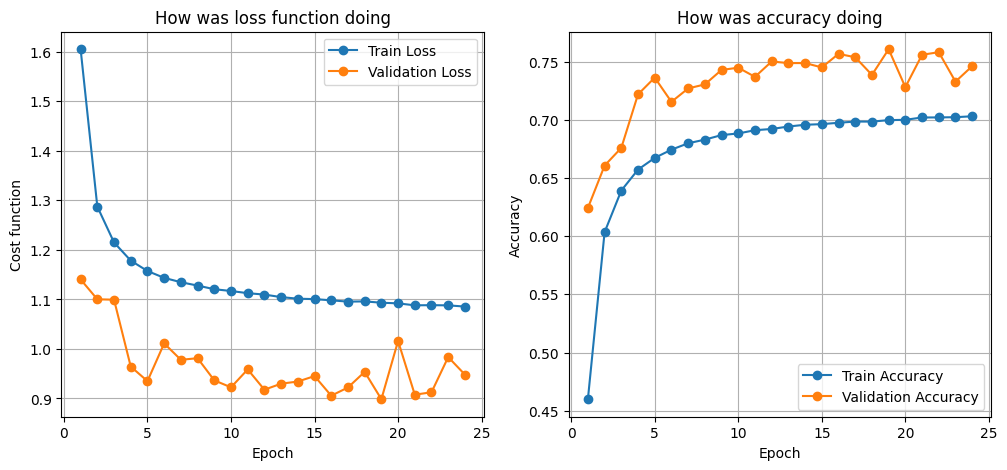

Found 90000 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.7717 - loss: 0.8676
Test Loss: 0.9058
Test Accuracy: 0.7579
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step


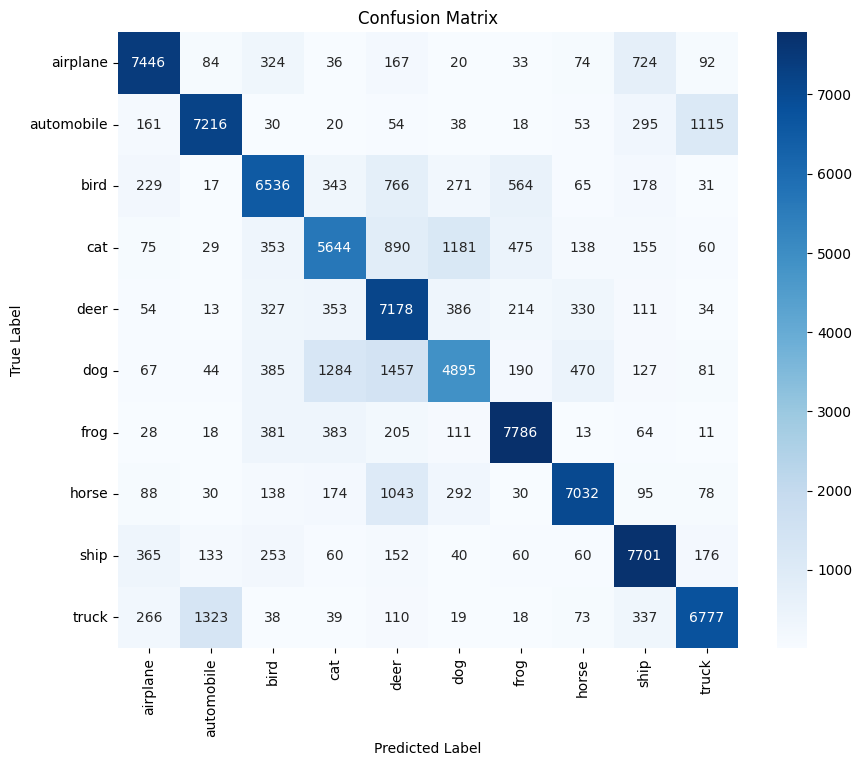

Classification Report:
              precision    recall  f1-score   support

    airplane       0.85      0.83      0.84      9000
  automobile       0.81      0.80      0.81      9000
        bird       0.75      0.73      0.74      9000
         cat       0.68      0.63      0.65      9000
        deer       0.60      0.80      0.68      9000
         dog       0.67      0.54      0.60      9000
        frog       0.83      0.87      0.85      9000
       horse       0.85      0.78      0.81      9000
        ship       0.79      0.86      0.82      9000
       truck       0.80      0.75      0.78      9000

    accuracy                           0.76     90000
   macro avg       0.76      0.76      0.76     90000
weighted avg       0.76      0.76      0.76     90000



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

loss = history_vgg.history["loss"]
val_loss = history_vgg.history["val_loss"]
accuracy = history_vgg.history["accuracy"]
val_accuracy = history_vgg.history["val_accuracy"]
epochs_range = range(1, len(loss) + 1)

# Wykres funkcji kosztu
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label="Train Loss", marker="o")
plt.plot(epochs_range, val_loss, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Cost function")
plt.title("How was loss function doing")
plt.legend()
plt.grid(True)

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label="Train Accuracy", marker="o")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("How was accuracy doing")
plt.legend()
plt.grid(True)
plt.show()

# wykresy dla test
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator_full = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32,32),
    batch_size=32,
    class_mode="sparse",
    shuffle=False  # Ustawiamy shuffle=False, aby kolejność etykiet była poprawna
)
test_loss, test_accuracy = vgg.evaluate(test_generator_full)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generowanie predykcji
predictions = vgg.predict(test_generator_full)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator_full.classes
class_labels = list(test_generator_full.class_indices.keys())

# Macierz pomyłek (Confusion Matrix)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Klasyfikacyjny raport
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [ ]:
vgg.save("vgg.h5")

## 3.3) ResnNet34 Implementation

In [ ]:
import numpy as np
import os
import shutil
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (32, 32)
datagen = ImageDataGenerator(rescale=1.0/255)

# architektura RESNET
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import AdamW


# Residual block function
def residual_block(x, filters, stride=1):
    shortcut = x

    x = layers.Conv2D(filters, (3, 3), padding='same', strides=stride,
                      kernel_regularizer=regularizers.l2(0.0001), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(0.0001), use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut if dimensions change
    if stride != 1:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride,
                                 kernel_regularizer=regularizers.l2(0.0001), use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# Building ResNet-34 with Functional API
def build_resnet34(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(64, (3, 3), padding='same', strides=1, use_bias=False,
                      kernel_regularizer=regularizers.l2(0.0001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual Blocks: 3x Basic Blocks with 64 filters
    for _ in range(3):
        x = residual_block(x, 64)

    # Residual Blocks: 4x Basic Blocks with 128 filters (stride=2 on first block)
    x = residual_block(x, 128, stride=2)
    for _ in range(3):
        x = residual_block(x, 128)

    # Residual Blocks: 6x Basic Blocks with 256 filters (stride=2 on first block)
    x = residual_block(x, 256, stride=2)
    for _ in range(5):
        x = residual_block(x, 256)

    # Residual Blocks: 3x Basic Blocks with 512 filters (stride=2 on first block)
    x = residual_block(x, 512, stride=2)
    for _ in range(2):
        x = residual_block(x, 512)

    # Global Average Pooling and Dense output layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Creating the model
    model = models.Model(inputs, outputs)
    return model


resnet34 = build_resnet34() # buduje model resnet

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.01,
    decay_steps=50000,
    alpha=0.0001
)
optimizer = AdamW(learning_rate=lr_schedule)
# Compile model
resnet34.compile(optimizer=optimizer,
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

# Early Stopping and LR Reduction
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

history = resnet34.fit(
    train_generator_450k_all,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    epochs=150, # troche zwiekszylem ale i tak sie pewnie wywali wczesniej na early stopping
    callbacks=[early_stopping, lr_reduction]
)

Path to source dataset files: /root/.cache/kagglehub/datasets/mengcius/cinic10/versions/1
Path to maly_zbior files: /root/.cache/kagglehub/datasets/mengcius/cinic10/versions/maly_zbior
Path to maly_zbior_test files: /root/.cache/kagglehub/datasets/mengcius/cinic10/versions/maly_zbior_test
Epoch 1/150
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 315s 80ms/step - accuracy: 0.3004 - loss: 3.1544 - val_accuracy: 0.3793 - val_loss: 2.3410 - learning_rate: 0.0099
Epoch 2/150
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 256s 73ms/step - accuracy: 0.5214 - loss: 1.5334 - val_accuracy: 0.4090 - val_loss: 2.0328 - learning_rate: 0.0095
Epoch 3/150
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 256s 73ms/step - accuracy: 0.5545 - loss: 1.4331 - val_accuracy: 0.4788 - val_loss: 1.6616 - learning_rate: 0.0089
Epoch 4/150
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 257s 73ms/step - accuracy: 0.5701 - loss: 1.3845 - val_accuracy: 0.5824 - val_loss: 1.3265 - learning_rate: 0.0082
Epoch 5/150
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 259s 74ms/step - accuracy: 0.5814 -

TypeError: This optimizer was created with a `LearningRateSchedule` object as its `learning_rate` constructor argument, hence its learning rate is not settable. If you need the learning rate to be settable, you should instantiate the optimizer with a float `learning_rate` argument.

### 3.3.1) We observed plateau at epoch 19

### 3.4) ResnNet34 learning process visualization

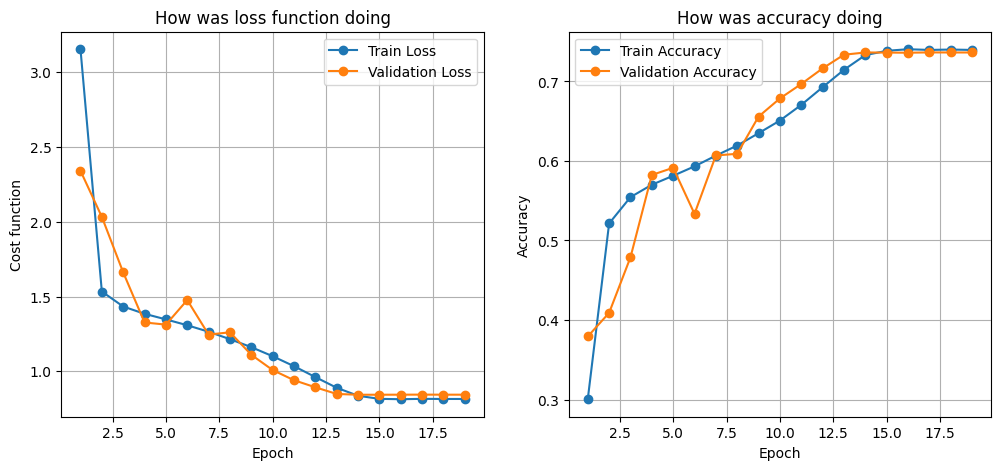

Found 90000 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.7458 - loss: 0.8166
Test Loss: 0.8600
Test Accuracy: 0.7319
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step


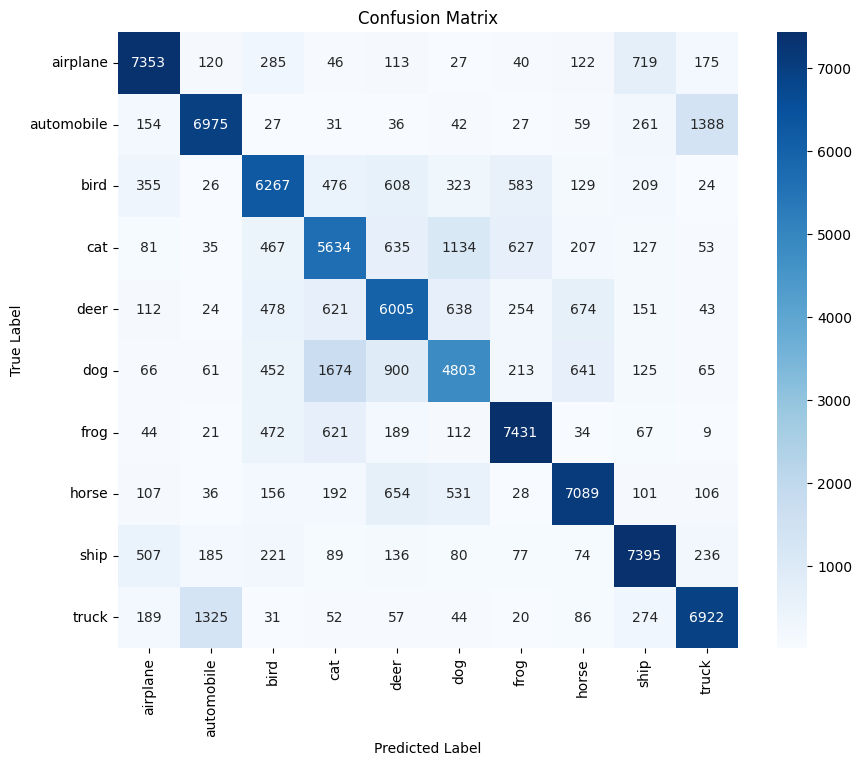

Classification Report:
              precision    recall  f1-score   support

    airplane       0.82      0.82      0.82      9000
  automobile       0.79      0.78      0.78      9000
        bird       0.71      0.70      0.70      9000
         cat       0.60      0.63      0.61      9000
        deer       0.64      0.67      0.66      9000
         dog       0.62      0.53      0.57      9000
        frog       0.80      0.83      0.81      9000
       horse       0.78      0.79      0.78      9000
        ship       0.78      0.82      0.80      9000
       truck       0.77      0.77      0.77      9000

    accuracy                           0.73     90000
   macro avg       0.73      0.73      0.73     90000
weighted avg       0.73      0.73      0.73     90000



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

loss = history_resnet34["loss"]
val_loss = history_resnet34["val_loss"]
accuracy = history_resnet34["accuracy"]
val_accuracy = history_resnet34["val_accuracy"]
epochs_range = range(1, len(loss) + 1)

# Wykres funkcji kosztu
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label="Train Loss", marker="o")
plt.plot(epochs_range, val_loss, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Cost function")
plt.title("How was loss function doing")
plt.legend()
plt.grid(True)

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label="Train Accuracy", marker="o")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("How was accuracy doing")
plt.legend()
plt.grid(True)
plt.show()

# wykresy dla test
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator_full = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32,32),
    batch_size=32,
    class_mode="sparse",
    shuffle=False  # Ustawiamy shuffle=False, aby kolejność etykiet była poprawna
)
test_loss, test_accuracy = resnet34.evaluate(test_generator_full)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generowanie predykcji
predictions = resnet34.predict(test_generator_full)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator_full.classes
class_labels = list(test_generator_full.class_indices.keys())

# Macierz pomyłek (Confusion Matrix)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Klasyfikacyjny raport
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

resnet34.save("resnet.h5")

## 3.5) GoogLeNet Implementation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

class InceptionModule(layers.Layer):
    def __init__(self, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
        super(InceptionModule, self).__init__()

        # Gałąź 1x1
        self.branch1x1 = models.Sequential([
            layers.Conv2D(filters_1x1, (1, 1), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001)),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

        # Gałąź 3x3 (1x1 -> 3x3)
        self.branch3x3 = models.Sequential([
            layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters_3x3, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001)),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

        # Gałąź 5x5 (1x1 -> 5x5)
        self.branch5x5 = models.Sequential([
            layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters_5x5, (5, 5), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001)),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

        # Gałąź pooling + 1x1
        self.branch_pool = models.Sequential([
            layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'),
            layers.Conv2D(filters_pool_proj, (1, 1), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001)),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

    def call(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)

        return layers.concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=-1)


def build_inception_v1(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()

    # Wstępna konwolucja
    model.add(layers.Conv2D(64, (3, 3), padding='same', use_bias=False, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

    # Moduły Inception
    model.add(InceptionModule(32, 32, 64, 16, 32, 32))
    model.add(InceptionModule(64, 48, 96, 16, 64, 64))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

    model.add(InceptionModule(128, 96, 128, 32, 64, 64))
    model.add(InceptionModule(128, 128, 192, 32, 96, 96))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

    model.add(InceptionModule(192, 160, 224, 64, 96, 96))
    model.add(InceptionModule(256, 160, 256, 64, 96, 96))

    # Globalne Average Pooling i Softmax
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Tworzenie modelu
inception_model = build_inception_v1()

optimizer = Adam(learning_rate=0.001)

inception_model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

# Trenowanie modelu
history = inception_model.fit(
    train_generator_450k_all,
    steps_per_epoch=(train_generator.samples + augmented_generator.samples) // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=100,
    callbacks=[early_stopping, lr_reduction]
)

Epoch 1/100
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5331 - loss: 1.6480

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 350s 88ms/step - accuracy: 0.5331 - loss: 1.6480 - val_accuracy: 0.6475 - val_loss: 1.2200 - learning_rate: 0.0010
Epoch 2/100
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 254s 72ms/step - accuracy: 0.7178 - loss: 1.0393 - val_accuracy: 0.6726 - val_loss: 1.2719 - learning_rate: 0.0010
Epoch 3/100
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 253s 72ms/step - accuracy: 0.7644 - loss: 0.9325 - val_accuracy: 0.7075 - val_loss: 1.2000 - learning_rate: 0.0010
Epoch 4/100
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 254s 72ms/step - accuracy: 0.7928 - loss: 0.8754 - val_accuracy: 0.7091 - val_loss: 1.2830 - learning_rate: 0.0010
Epoch 5/100
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 257s 73ms/step - accuracy: 0.8149 - loss: 0.8313 - val_accuracy: 0.6462 - val_loss: 1.6344 - learning_rate: 0.0010
Epoch 6/100
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 260s 74ms/step - accuracy: 0.8210 - loss: 0.8237 - val_accuracy: 0.7203 - val_loss: 1.1972 - learning_rate: 0.0010
Epoch 7/100
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 258s 73ms/step - accu

### 3.6) GoogLeNet learning process visualization

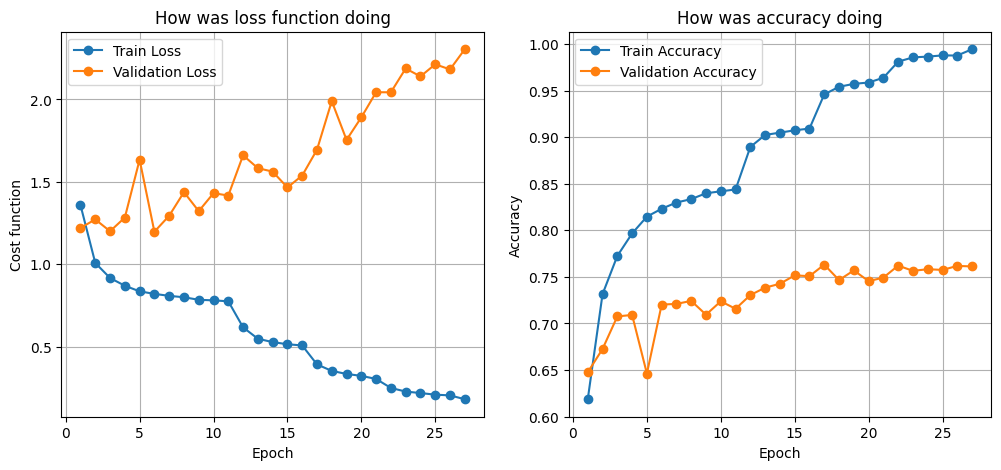

Found 90000 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.7658 - loss: 1.6617
Test Loss: 1.7180
Test Accuracy: 0.7612
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step


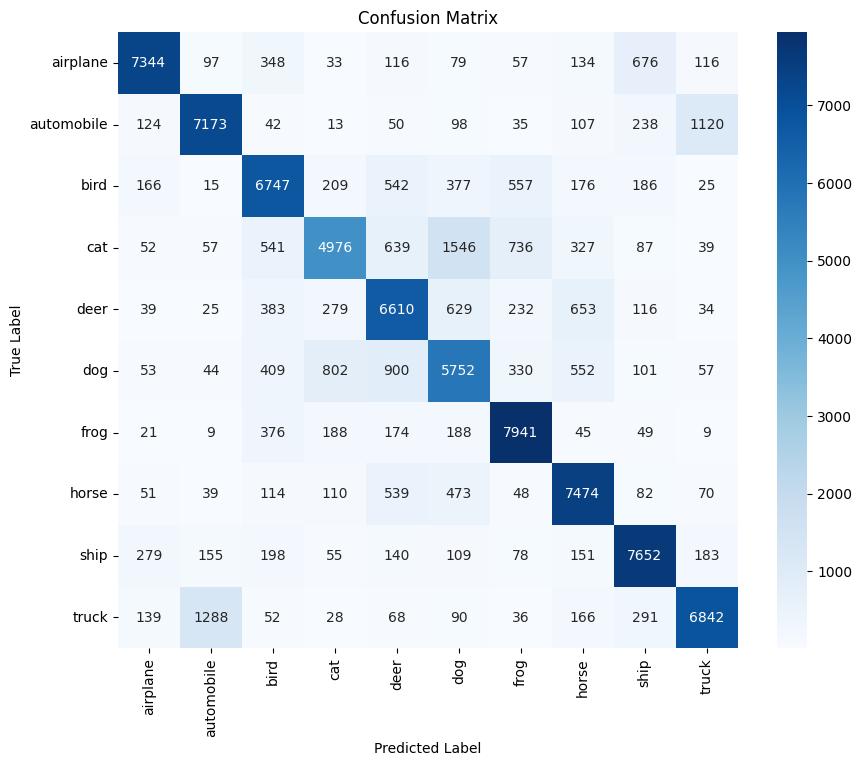

Classification Report:
              precision    recall  f1-score   support

    airplane       0.89      0.82      0.85      9000
  automobile       0.81      0.80      0.80      9000
        bird       0.73      0.75      0.74      9000
         cat       0.74      0.55      0.63      9000
        deer       0.68      0.73      0.70      9000
         dog       0.62      0.64      0.63      9000
        frog       0.79      0.88      0.83      9000
       horse       0.76      0.83      0.80      9000
        ship       0.81      0.85      0.83      9000
       truck       0.81      0.76      0.78      9000

    accuracy                           0.76     90000
   macro avg       0.76      0.76      0.76     90000
weighted avg       0.76      0.76      0.76     90000



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs_range = range(1, len(loss) + 1)

# Wykres funkcji kosztu
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label="Train Loss", marker="o")
plt.plot(epochs_range, val_loss, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Cost function")
plt.title("How was loss function doing")
plt.legend()
plt.grid(True)

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label="Train Accuracy", marker="o")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("How was accuracy doing")
plt.legend()
plt.grid(True)
plt.show()

# wykresy dla test
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator_full = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32,32),
    batch_size=32,
    class_mode="sparse",
    shuffle=False  # Ustawiamy shuffle=False, aby kolejność etykiet była poprawna
)
test_loss, test_accuracy = inception_model.evaluate(test_generator_full)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generowanie predykcji
predictions = inception_model.predict(test_generator_full)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator_full.classes
class_labels = list(test_generator_full.class_indices.keys())

# Macierz pomyłek (Confusion Matrix)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Klasyfikacyjny raport
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

## 3.7) ResnNet16 Implementation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definicja bloku resztkowego (residual BasicBlock)
def residual_block(x, filters, stride=1):
    # Kopia wejścia do ścieżki shortcut
    shortcut = x

    # Pierwsza warstwa Conv-BN-ReLU
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same',
                      use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Druga warstwa Conv-BN (bez aktywacji tutaj)
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same',
                      use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    # (Nie zastosowano ReLU przed dodaniem shortcut)

    # Dopasowanie shortcut, jeśli zmieniono liczbę filtrów lub stride
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride,
                                 padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Zsumowanie ścieżki głównej i shortcut
    x = layers.Add()([x, shortcut])
    # Końcowa aktywacja ReLU bloku
    x = layers.ReLU()(x)
    return x

# Wejście do modelu
input_tensor = layers.Input(shape=(32, 32, 3))

# Początkowa warstwa konwolucyjna + BN + ReLU (64 filtry, rozmiar 3x3, stride=1)
x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', use_bias=False)(input_tensor)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Bloki ResNet-18:
# 2 bloki z 64 filtrami (stride=1 w pierwszym segmencie)
x = residual_block(x, filters=64, stride=1)
x = residual_block(x, filters=64, stride=1)

# 2 bloki z 128 filtrami (pierwszy ze stride=2 dla redukcji rozdzielczości)
x = residual_block(x, filters=128, stride=2)
x = residual_block(x, filters=128, stride=1)

# 2 bloki z 256 filtrami (pierwszy ze stride=2)
x = residual_block(x, filters=256, stride=2)
x = residual_block(x, filters=256, stride=1)

# 2 bloki z 512 filtrami (pierwszy ze stride=2)
x = residual_block(x, filters=512, stride=2)
x = residual_block(x, filters=512, stride=1)

# Global Average Pooling 2D
x = layers.GlobalAveragePooling2D()(x)

# Warstwa wyjściowa Dense z softmax (10 klas)
output_tensor = layers.Dense(10, activation='softmax')(x)


model = models.Model(inputs=input_tensor, outputs=output_tensor)
optimizer = Adam(learning_rate=0.001)

# Kompilacja modelu
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks: EarlyStopping i ReduceLROnPlateau
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

# Trenowanie modelu
history = model.fit(
    train_generator_450k_all,
    steps_per_epoch=(train_generator.samples + augmented_generator.samples) // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=100,
    callbacks=[early_stopping, lr_reduction]
)

Epoch 1/100
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 297s 78ms/step - accuracy: 0.5200 - loss: 1.3474 - val_accuracy: 0.6954 - val_loss: 0.9103 - learning_rate: 0.0010
Epoch 2/100
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 252s 72ms/step - accuracy: 0.7695 - loss: 0.6523 - val_accuracy: 0.7380 - val_loss: 0.9280 - learning_rate: 0.0010
Epoch 3/100
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 252s 72ms/step - accuracy: 0.8671 - loss: 0.3828 - val_accuracy: 0.7430 - val_loss: 1.3277 - learning_rate: 0.0010
Epoch 4/100
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 252s 72ms/step - accuracy: 0.9114 - loss: 0.2562 - val_accuracy: 0.7562 - val_loss: 1.3114 - learning_rate: 0.0010
Epoch 5/100
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 254s 72ms/step - accuracy: 0.9412 - loss: 0.1671 - val_accuracy: 0.7538 - val_loss: 1.5431 - learning_rate: 0.0010
Epoch 6/100
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9624 - loss: 0.1071
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 258s 73ms/ste

### 3.8) ResnNet34 learning process visualization

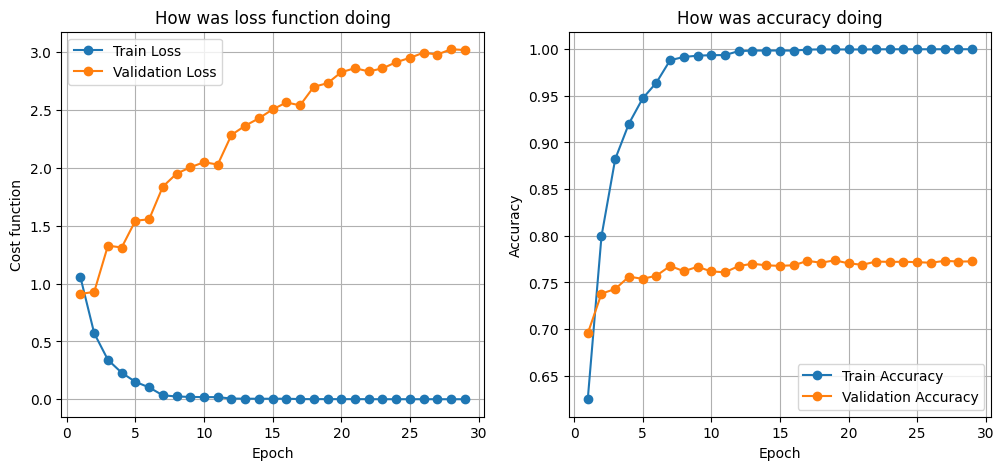

Found 90000 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.7910 - loss: 2.5003
Test Loss: 2.7670
Test Accuracy: 0.7723
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step


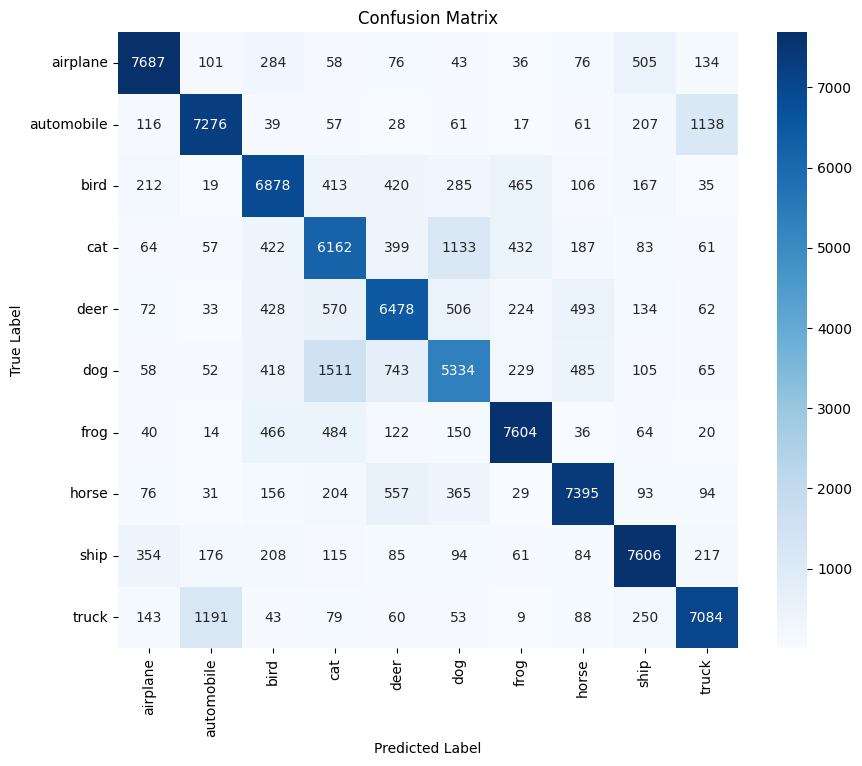

Classification Report:
              precision    recall  f1-score   support

    airplane       0.87      0.85      0.86      9000
  automobile       0.81      0.81      0.81      9000
        bird       0.74      0.76      0.75      9000
         cat       0.64      0.68      0.66      9000
        deer       0.72      0.72      0.72      9000
         dog       0.66      0.59      0.63      9000
        frog       0.84      0.84      0.84      9000
       horse       0.82      0.82      0.82      9000
        ship       0.83      0.85      0.84      9000
       truck       0.80      0.79      0.79      9000

    accuracy                           0.77     90000
   macro avg       0.77      0.77      0.77     90000
weighted avg       0.77      0.77      0.77     90000



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs_range = range(1, len(loss) + 1)

# Wykres funkcji kosztu
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label="Train Loss", marker="o")
plt.plot(epochs_range, val_loss, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Cost function")
plt.title("How was loss function doing")
plt.legend()
plt.grid(True)

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label="Train Accuracy", marker="o")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("How was accuracy doing")
plt.legend()
plt.grid(True)
plt.show()

# wykresy dla test
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator_full = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32,32),
    batch_size=32,
    class_mode="sparse",
    shuffle=False  # Ustawiamy shuffle=False, aby kolejność etykiet była poprawna
)
test_loss, test_accuracy = model.evaluate(test_generator_full)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generowanie predykcji
predictions = model.predict(test_generator_full)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator_full.classes
class_labels = list(test_generator_full.class_indices.keys())

# Macierz pomyłek (Confusion Matrix)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Klasyfikacyjny raport
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# 4) Summary

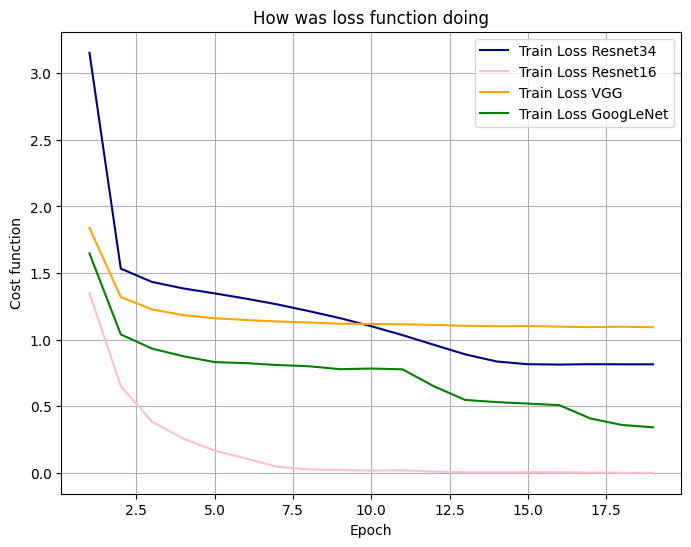

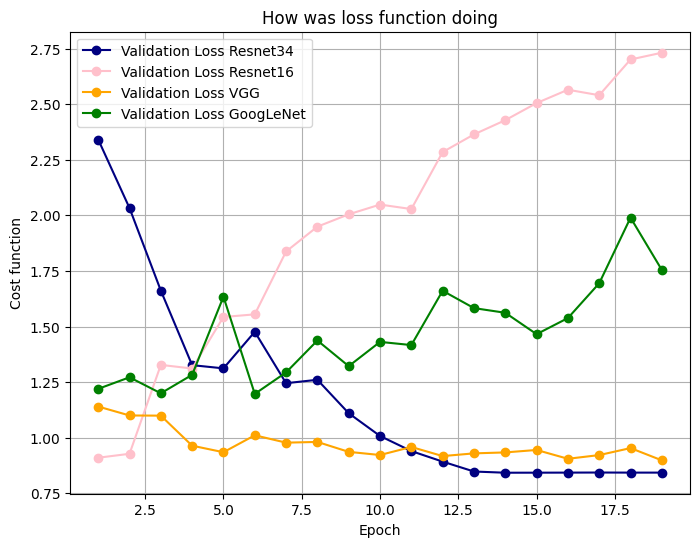

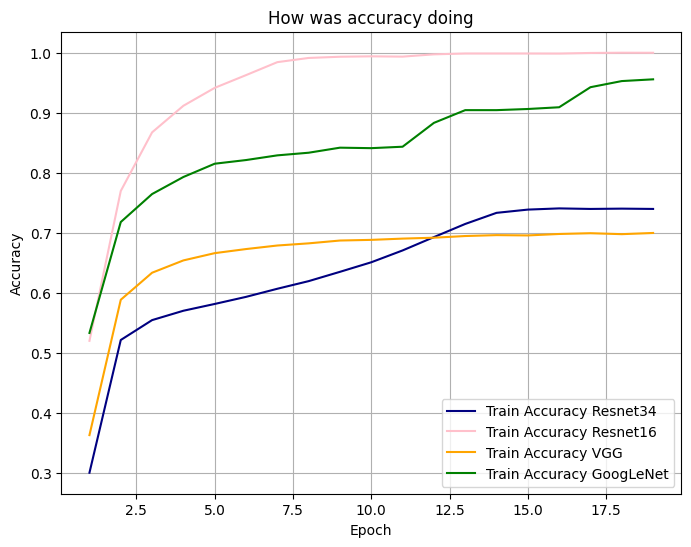

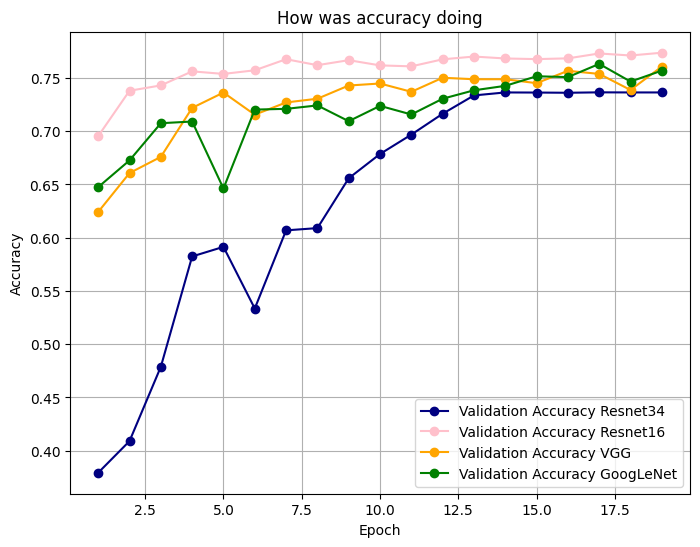

In [ ]:
history_vgg = {
    'loss': [1.8387, 1.3197, 1.2268, 1.1839, 1.1609, 1.1473, 1.1365, 1.1287, 1.1198, 1.1180, 1.1152, 1.1103, 1.1038, 1.1015, 1.1022, 1.0979, 1.0936, 1.0976, 1.0928, 1.0930, 1.0882, 1.0899, 1.0882, 1.0854],
    'val_loss': [1.1404, 1.1003, 1.0995, 0.9644, 0.9351, 1.0112, 0.9781, 0.9813, 0.9367, 0.9225, 0.9587, 0.9177, 0.9299, 0.9342, 0.9452, 0.9056, 0.9222, 0.9537, 0.8985, 1.0161, 0.9077, 0.9126, 0.9836, 0.9482],
    'accuracy': [0.3630, 0.5884, 0.6334, 0.6539, 0.6660, 0.6728, 0.6787, 0.6823, 0.6870, 0.6881, 0.6902, 0.6917, 0.6945, 0.6960, 0.6955, 0.6979, 0.6992, 0.6976, 0.6996, 0.6998, 0.7019, 0.7015, 0.7026, 0.7030],
    'val_accuracy': [0.6242, 0.6607, 0.6759, 0.7219, 0.7363, 0.7155, 0.7270, 0.7305, 0.7429, 0.7448, 0.7370, 0.7502, 0.7488, 0.7488, 0.7451, 0.7567, 0.7538, 0.7387, 0.7607, 0.7281, 0.7559, 0.7582, 0.7329, 0.7462]
}
history_resnet34 = {
    'loss': [3.1544, 1.5334, 1.4331, 1.3845, 1.3471, 1.3079, 1.2645, 1.2147, 1.1614, 1.1007, 1.0340, 0.9612, 0.8896, 0.8362, 0.8155, 0.8130, 0.8155, 0.8147, 0.8147],
    'val_loss': [2.3410, 2.0328, 1.6616, 1.3265, 1.3121, 1.4765, 1.2454, 1.2607, 1.1104, 1.0081, 0.9402, 0.8928, 0.8483, 0.8429, 0.8431, 0.8434, 0.8438, 0.8434, 0.8434],
    'accuracy': [0.3004, 0.5214, 0.5545, 0.5701, 0.5814, 0.5932, 0.6067, 0.6194, 0.6349, 0.6508, 0.6705, 0.6927, 0.7146, 0.7331, 0.7385, 0.7405, 0.7396, 0.7401, 0.7396],
    'val_accuracy': [0.3793, 0.4090, 0.4788, 0.5824, 0.5914, 0.5335, 0.6069, 0.6090, 0.6558, 0.6786, 0.6968, 0.7164, 0.7336, 0.7364, 0.7363, 0.7361, 0.7365, 0.7364, 0.7364]
}
history_inception = {
    "loss": [1.6480, 1.0393, 0.9325, 0.8754, 0.8313, 0.8237, 0.8094, 0.8004, 0.7782, 0.7832, 0.7770, 0.6497, 0.5472, 0.5312, 0.5198, 0.5085, 0.4081, 0.3595, 0.3416],
    "val_loss": [1.2200, 1.2719, 1.2000, 1.2830, 1.6344, 1.1972, 1.2940, 1.4374, 1.3220, 1.4311, 1.4168, 1.6609, 1.5830, 1.5620, 1.4658, 1.5382, 1.6947, 1.9897, 1.7545],
    "accuracy": [0.5331, 0.7178, 0.7644, 0.7928, 0.8149, 0.8210, 0.8288, 0.8332, 0.8416, 0.8408, 0.8432, 0.8829, 0.9041, 0.9041, 0.9060, 0.9089, 0.9423, 0.9525, 0.9554],
    "val_accuracy": [0.6475, 0.6726, 0.7075, 0.7091, 0.6462, 0.7203, 0.7210, 0.7242, 0.7094, 0.7238, 0.7157, 0.7305, 0.7384, 0.7426, 0.7516, 0.7508, 0.7632, 0.7466, 0.7569]
}

history_resnet16 = {
    "loss": [1.3474, 0.6523, 0.3828, 0.2562, 0.1671, 0.1071, 0.0456, 0.0255, 0.0202, 0.0179, 0.0189, 0.0086, 0.0045, 0.0043, 0.0046, 0.0048, 0.0022, 0.0008, 0.0011],
    "val_loss": [0.9103, 0.9280, 1.3277, 1.3114, 1.5431, 1.5549, 1.8376, 1.9492, 2.0047, 2.0485, 2.0283, 2.2846, 2.3639, 2.4279, 2.5048, 2.5648, 2.5401, 2.7008, 2.7312],
    "accuracy": [0.5200, 0.7695, 0.8671, 0.9114, 0.9412, 0.9624, 0.9840, 0.9910, 0.9930, 0.9937, 0.9932, 0.9970, 0.9984, 0.9984, 0.9984, 0.9983, 0.9993, 0.9997, 0.9996],
    "val_accuracy": [0.6954, 0.7380, 0.7430, 0.7562, 0.7538, 0.7572, 0.7676, 0.7620, 0.7667, 0.7618, 0.7609, 0.7675, 0.7701, 0.7683, 0.7677, 0.7684, 0.7730, 0.7711, 0.7737],
    "learning_rate": [0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00025, 0.00025, 0.00025, 0.00025, 0.00025, 0.000125, 0.000125, 0.000125]
}


loss = history_resnet34["loss"]
val_loss = history_resnet34["val_loss"]
accuracy = history_resnet34["accuracy"]
val_accuracy = history_resnet34["val_accuracy"]
epochs_range = range(1, len(loss) + 1)

loss_vgg = history_vgg["loss"]
val_loss_vgg = history_vgg["val_loss"]
accuracy_vgg = history_vgg["accuracy"]
val_accuracy_vgg = history_vgg["val_accuracy"]

loss_inception = history_inception["loss"]
val_loss_inception = history_inception["val_loss"]
accuracy_inception = history_inception["accuracy"]
val_accuracy_inception = history_inception["val_accuracy"]

loss_res16 = history_resnet16["loss"]
val_loss_res16 = history_resnet16["val_loss"]
accuracy_res16 = history_resnet16["accuracy"]
val_accuracy_res16 = history_resnet16["val_accuracy"]

# Wykres funkcji kosztu
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label="Train Loss Resnet34", color="navy")
plt.plot(epochs_range, loss_res16, label="Train Loss Resnet16", color="pink")
plt.plot(epochs_range, loss_vgg[:19], label="Train Loss VGG", color="orange")
plt.plot(epochs_range, loss_inception[:19], label="Train Loss GoogLeNet", color="green")
plt.xlabel("Epoch")
plt.ylabel("Cost function")
plt.title("How was loss function doing")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, val_loss, label="Validation Loss Resnet34", marker="o", color="navy")
plt.plot(epochs_range, val_loss_res16, label="Validation Loss Resnet16", marker="o", color="pink")
plt.plot(epochs_range, val_loss_vgg[:19], label="Validation Loss VGG", marker="o", color="orange")
plt.plot(epochs_range, val_loss_inception[:19], label="Validation Loss GoogLeNet", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("Cost function")
plt.title("How was loss function doing")
plt.legend()
plt.grid(True)
plt.show()

# Wykres dokładności
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, accuracy, label="Train Accuracy Resnet34", color="navy")
plt.plot(epochs_range, accuracy_res16, label="Train Accuracy Resnet16", color="pink")
plt.plot(epochs_range, accuracy_vgg[:19], label="Train Accuracy VGG", color="orange")
plt.plot(epochs_range, accuracy_inception[:19], label="Train Accuracy GoogLeNet", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("How was accuracy doing")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy Resnet34", marker="o", color="navy")
plt.plot(epochs_range, val_accuracy_res16, label="Validation Accuracy Resnet16", marker="o", color="pink")
plt.plot(epochs_range, val_accuracy_vgg[:19], label="Validation Accuracy VGG", marker="o", color="orange")
plt.plot(epochs_range, val_accuracy_inception[:19], label="Validation Accuracy GoogLeNet", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("How was accuracy doing")
plt.legend()
plt.grid(True)
plt.show()
